1. Nettoyage
2. Analyse des variables
3. Encodage (OneHot, LabelEncoder...)
4. Normalisation (et centrage)
5. Split données
6. Fit sur X_train, y_train 
7. Score sur X_test, y_test

**Améliorations:**
1. Catégoriser
2. PolynomialFeatures
3. Suppression des outliers influants avec la distance de Cook
4. CrossValidation

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('data/data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


# Split des data

In [3]:
df.sex = df.sex.astype('category')
df.smoker = df.smoker.astype('category')
df.region = df.region.astype('category')

y = df['charges']
df = df.drop('charges', axis=1)
X = df[['age', 'sex', 'bmi', 'children', 'smoker', 'region']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=.85)
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('y_train', X_train.shape)
print('y_test', X_test.shape)

X_train (1137, 6)
X_test (201, 6)
y_train (1137, 6)
y_test (201, 6)


array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'children'}>, <Axes: >]], dtype=object)

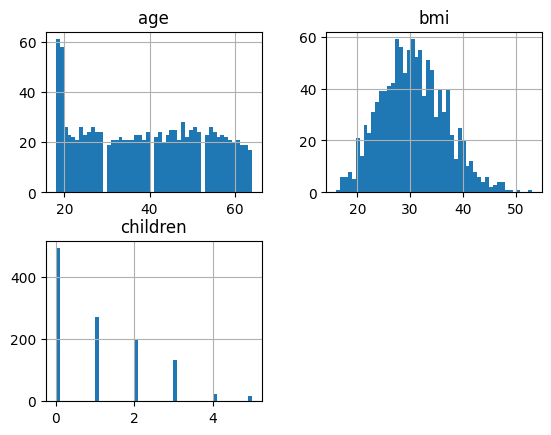

In [4]:
X_train.hist(bins=50)

# Test entre 2 méthodes

### init

In [5]:

from sklearn import set_config
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.linear_model import Lasso, LassoCV, LinearRegression

from feature_engine.encoding import OneHotEncoder, OrdinalEncoder
from feature_engine.discretisation import ArbitraryDiscretiser

set_config(transform_output = "pandas")

alphas = np.linspace(1, 200, 50)
bmi_dict = {'bmi': [0, 18.5, 25, 30, 40, np.Inf]}

## Pipeline

In [6]:
pipe_bmi = make_pipeline(
    ArbitraryDiscretiser(binning_dict=bmi_dict, return_object=False, return_boundaries=True),
    OneHotEncoder(variables=['bmi'])
)

transformers = make_column_transformer(
    (OneHotEncoder(variables=['region']), ['region']),
    (OrdinalEncoder(variables=['smoker', 'sex']), ['smoker', 'sex']),
    (pipe_bmi, ['bmi']),
    remainder='passthrough'
)

#np.set_printoptions(threshold=np.inf)

df_X_train = transformers.fit_transform(X_train, y_train)
df_X_train.head()

,onehotencoder__region_northwest,onehotencoder__region_southeast,onehotencoder__region_southwest,onehotencoder__region_northeast,ordinalencoder__smoker,ordinalencoder__sex,"pipeline__bmi_(25.0, 30.0]","pipeline__bmi_(40.0, inf]","pipeline__bmi_(18.5, 25.0]","pipeline__bmi_(30.0, 40.0]","pipeline__bmi_(-0.001, 18.5]",remainder__age,remainder__children
331,1,0,0,0,1,1,1,0,0,0,0,52,0
796,0,1,0,0,0,1,0,1,0,0,0,30,2
1039,1,0,0,0,0,1,1,0,0,0,0,19,2
261,0,1,0,0,1,0,1,0,0,0,0,20,1
70,0,1,0,0,1,0,0,0,1,0,0,27,0


# Cook distance

## Visualisation

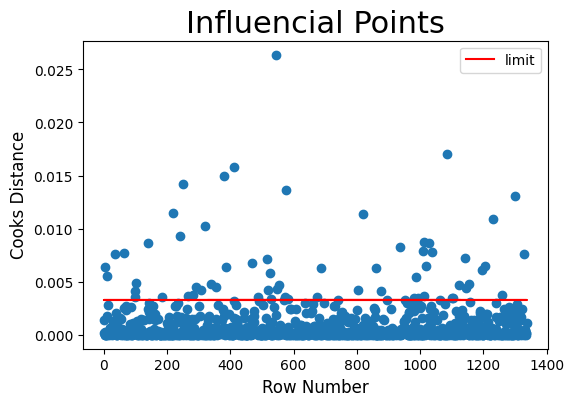

In [7]:
import statsmodels.api as sm

y_train_cook = y_train.copy()

df_X_train = sm.add_constant(df_X_train)
model_cook = sm.OLS(y_train_cook, df_X_train).fit()
influence = model_cook.get_influence()

#obtain Cook's distance for each observation
cooks = influence.cooks_distance 
mean_cooks = np.mean(cooks[0])
mean_cooks_list = [4 * mean_cooks for i in df_X_train.index]

# Draw plot
plt.figure(figsize = (6, 4))
plt.scatter(df_X_train.index, cooks[0])
#plt.plot(df_X_train.index, cooks[0], color='black')
plt.plot(df_X_train.index, mean_cooks_list, color="red", label='limit')
plt.xlabel('Row Number', fontsize = 12)
plt.ylabel('Cooks Distance', fontsize = 12)
plt.title('Influencial Points', fontsize = 22)
plt.legend()
plt.show()


## Points d'influence

In [8]:
# Influencial points
influencial_points = df_X_train.index[cooks[0] > 4 * mean_cooks]
influencial_points

Index([1039,  739,  306,  543, 1142,  140,  380,  526,  554,  987,  266,  583,
        355,  292,  549, 1008,  321,  242, 1328,    3, 1085,  573, 1062,  803,
       1146,   62,  281, 1011,  250,    9,  936,  530,  516,  185,  468, 1258,
       1230,  688,  412, 1027,  674,   99,  340,  994, 1206,  819, 1156,  876,
        102, 1195,  980, 1100, 1019, 1124, 1300,  896,  488,  219, 1012,  577,
         98,  520, 1104,   34,  387,  860],
      dtype='int64')

## Suppression des points d'influence
Ne pas le faire sur le jeu de test

In [9]:
print(len(X_train), len(y_train), f'suppression de : {len(influencial_points)} points')

X_train.drop(index=influencial_points, inplace=True)
y_train.drop(index=influencial_points, inplace=True)

print(len(X_train), len(y_train))

1137 1137 suppression de : 66 points
1071 1071


## GridSearchCV

### Model fit

In [10]:
from sklearn.model_selection import GridSearchCV

pipe = make_pipeline(
                    transformers, 
                    PolynomialFeatures(interaction_only=False, include_bias=False), 
                    StandardScaler(),
                    Lasso(max_iter=1000000, tol=1e-4)
                )

#print(pipe.get_params()) --> pour récupérer les paramètres pour le cv du modèle

alphas = np.arange(68, 69, .01)
grid = GridSearchCV(pipe, {'lasso__alpha': alphas}, cv=3)
grid.fit(X_train, y_train.values)

predictions = grid.predict(X_test)
mse = mean_squared_error(y_test.values, predictions, squared=False)
print('RMSE :', mse)
print('best score : ', grid.best_score_) # 0.9272990772973468
print('best params : ', grid.best_params_)

RMSE : 4057.594913553315
best score :  0.9272990873557045
best params :  {'lasso__alpha': 68.09000000000005}


### Affichage des coefficients

In [11]:
display(grid)
#print(grid.best_estimator_.named_steps.lasso.coef_)
# col_region = pipe.named_steps['columntransformer'].named_transformers_['onehotencoder'].get_feature_names_out()
# col_smoker_sex = pipe.named_steps['columntransformer'].named_transformers_['ordinalencoder'].get_feature_names_out()
# col_bmi = pipe.named_steps['columntransformer'].named_transformers_['pipeline'].get_feature_names_out()
# col_remain = pipe.named_steps['columntransformer'].named_transformers_['remainder']
# cols = col_region + col_smoker_sex + col_bmi
#print(pipe.named_steps['polynomialfeatures'].fit(X_train).get_feature_names_out())


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(variables=['region']),
                                                                         ['region']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(variables=['smoker',
                                                                                                   'sex']),
                                                                         ['smoker',
                                                                          'sex']),
                                                                        ('pipeline',
                                                                         Pipeline(steps=[('arbitrarydiscretiser',
                                                                                          ArbitraryDiscretiser(binning_dict...
       68.36, 68.37, 68.38, 68.39, 68.4 , 68.41, 68.42, 68.43, 68.44,
       68.45, 68.46, 68.47, 68.48, 68.49, 68.5 , 68.51, 68.52, 68.53,
       68.54, 68.55, 68.56, 68.57, 68.58, 68.59, 68.6 , 68.61, 68.62,
       68.63, 68.64, 68.65, 68.66, 68.67, 68.68, 68.69, 68.7 , 68.71,
       68.72, 68.73, 68.74, 68.75, 68.76, 68.77, 68.78, 68.79, 68.8 ,
       68.81, 68.82, 68.83, 68.84, 68.85, 68.86, 68.87, 68.88, 68.89,
       68.9 , 68.91, 68.92, 68.93, 68.94, 68.95, 68.96, 68.97, 68.98,
       68.99])})

['onehotencoder__region',
 'ordinalencoder__smoker',
 'ordinalencoder__sex',
 'pipeline__bmi',
 'x0',
 'x3']

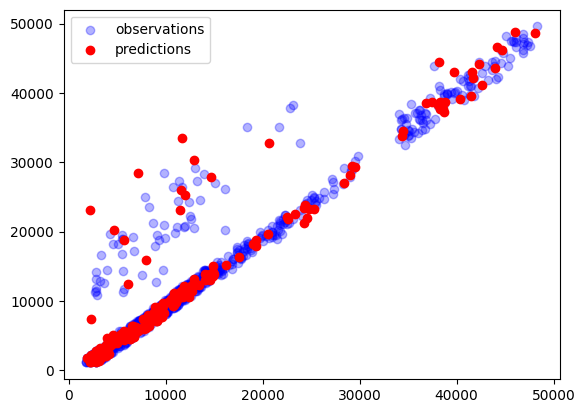

In [112]:
predictions = grid.best_estimator_.predict(X_test)
observations = grid.best_estimator_.predict(X_train)

plt.scatter(observations, y_train, color='blue', alpha=.3, label='observations')
plt.scatter(predictions, y_test, color='red', label='predictions')
plt.legend()

### Sauvegarde du model

In [113]:
import pickle
model_path = 'data/model_grid.pickle'
save_comp = {
    'model': grid.best_estimator_
}
pickle.dump(save_comp, open(model_path, 'wb')) # Save model dans data

## LassoCV

### Model fit

In [92]:
pipe = make_pipeline(
            transformers,
            PolynomialFeatures(interaction_only=False), 
            StandardScaler(with_mean=False),
            #MinMaxScaler(),
            LassoCV(alphas=alphas, fit_intercept=False, max_iter=1000000, cv=5)
        )

pipe.fit(X_train, y_train)
score = pipe.score(X_test, y_test)
predictions = pipe.predict(X_test)
mse = mean_squared_error(y_test, predictions, squared=False)
#print(pipe.named_steps)
print('Score :', score)
print('RMSE :', mse)
print('alpha :', pipe.named_steps.lassocv.alpha_)

Score : 0.8916193340960263
RMSE : 4062.3734432925075
alpha : 90.34693877551021


### Sauvegarde du model

In [93]:
import pickle
model_path = 'data/model_cv.pickle'
save_comp = {
    'model': pipe
}
pickle.dump(save_comp, open(model_path, 'wb')) # Save model dans data

### Graph

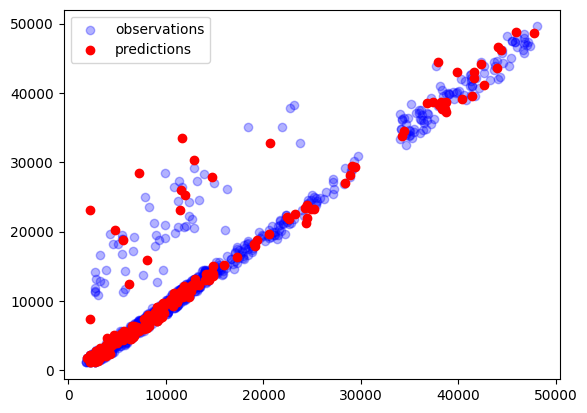

In [94]:
predictions = pipe.predict(X_test)
observations = pipe.predict(X_train)

plt.scatter(observations, y_train, color='blue', alpha=.3, label='observations')
plt.scatter(predictions, y_test, color='red', label='predictions')
plt.legend()

# Discrétisation de bmi pour la démo

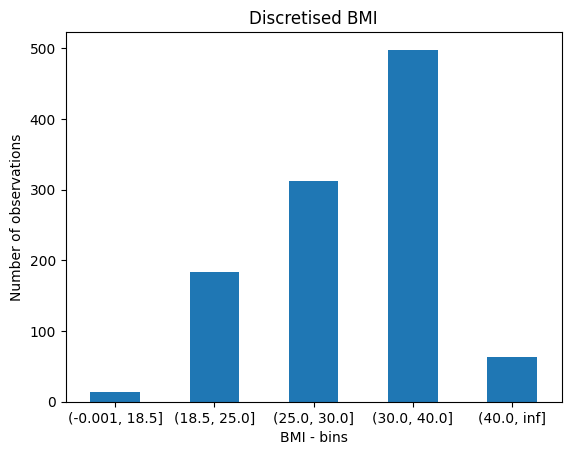

In [95]:
from feature_engine.discretisation import ArbitraryDiscretiser

bmi_dict = {'bmi': [0, 18.5, 25, 30, 40, np.Inf]}
transformer = ArbitraryDiscretiser(binning_dict=bmi_dict, return_object=False, return_boundaries=True)

bmi = transformer.fit_transform(X_train)
bmi['bmi'].value_counts(ascending=True).sort_index().plot.bar(rot=0)
plt.xlabel('BMI - bins')
plt.ylabel('Number of observations')
plt.title('Discretised BMI')
plt.show()

# chargement du model et prédiction

In [96]:
model_path = 'data/model_grid.pickle'
m = pickle.load(open(model_path, 'rb'))
model = m['model']

# test predict sur un individu
t = pd.DataFrame(
                [['no', 'male', 18, 15.0, 0, 'northeast']], 
                 columns = ['smoker', 'sex', 'age', 'bmi', 'children', 'region']
                 )
display(t.head())
model.predict(t)


,smoker,sex,age,bmi,children,region
0,no,male,18,15.0,0,northeast


array([2225.10659569])

## Regression linéaire

Score : 0.7920052062681768
MSE : 5627.690035097389


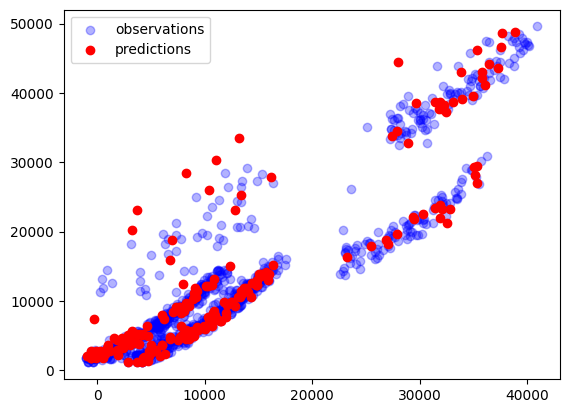

In [97]:
from sklearn.linear_model import LinearRegression

pipe = make_pipeline(
                    transformers, 
                    MinMaxScaler(),
                    LinearRegression()
                )

pipe.fit(X_train, y_train)
score = pipe.score(X_test, y_test)

predictions = pipe.predict(X_test)
mse = mean_squared_error(y_test, predictions, squared=False)
print('Score :', score)
print('MSE :', mse)

observations = pipe.predict(X_train)
plt.scatter(observations, y_train, color='blue', alpha=.3, label='observations')
plt.scatter(predictions, y_test, color='red', label='predictions')
plt.legend()